# Atmospheric River identification

Second part of the algorithm for tracking atmospheric rivers, adapted from Erik Swenson's code.

1. Read in moisture fluxes
2. Calculate moisture flux magnitudes
3. Determine the probability distribution of the flux magnitudes
4. Using probability distribution, determine appropriate threshold for identifying AR (e.g. 95 percentile)
5. Identify AR using:
    
        a. Flux magnitude threshold to obtain AR objects
    
        b. Check net direction of moisture flux in object is poleward and eastward
    
        c. Check object shape has length > 2000km and width < 1000 km
    
        d. Check median latitude poleward of 20N
        
6. Obtain count of AR occurrences at each grid point
7. Plot AR occurrences

* Input:
    Moisture flux
    
    `/glade/work/mkorendy/metisregimes/resolution/metis.variable_pna_months.1986-2016.nc`
    
* Output:
    Atmospheric river maps
    
    `metisres.AR.threshold.PNA.months.png`

## Haversine distance

In [1]:
# For calculating the length and width of the atmospheric rivers in kilometers
# Converts coordinates into kilometers

def haversine(coord1, coord2):
    R = 6372.800  # Earth radius in kilometers
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

## Imports

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import cartopy.crs as ccrs
from skimage.segmentation import watershed
import math

## Constants

In [3]:
# method for detecting AR
imethod = 0

#resolution (metis: 199, 639, 1279; ERA5: native, N32, N128)
res = 'N128'
resolution = 'tco' + res

# Years to calculate for:
yrs = ['1986','2016']

#ERA5?
era5 = True

threshold = '10%'
crit_val = 259.0

## Files

In [4]:
#Path
if resolution == 'tco199' or era5 == True:
    path = '/glade/work/mkorendy/metisregimes/'
else:
    path = '/glade/work/mkorendy/metisregimes/' + resolution + '/'

# Moisture flux input
if era5 == False:
    if res != '1279':
        f_u = path + 'metis.uqvi_pna_NDJFM.1986-2016.nc'
        f_v = path + 'metis.vqvi_pna_NDJFM.1986-2016.nc'
    else:
        f_u = path + 'metis.uqvi_pna_ND.1986-2016.nc'
        f_v = path + 'metis.vqvi_pna_ND.1986-2016.nc'
else:
    if res == 'N32':
        f_v = path + 'era5.AR.vqvi_pna_NDJFM.1986-2016.nc'
    elif res == 'native':
        f_v = path + 'era5.AR.vqvi_pna_NDJFM.1986-2016.reg_grid.nc'
    else:
        f_v = path + 'era5.AR.vqvi_pna_NDJFM.1986-2016.N128.nc'
    #2016 data:
    #f_v = path + 'era5.AR.vqvi_pna_NDJFM.2016.nc'

# Grab filter times
if res != '1279':
    f_times = path + 'metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.nc'
else:
    f_times = path + 'metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.nc'

# Output
if era5 == False:
    if res != '1279':
        f_pic = '/glade/u/home/mkorendy/metisregimes/metis' + res + '.AR.' + threshold + '.PNA.NDJFM.png'
        f_out = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.nc'
    else:
        f_pic = '/glade/u/home/mkorendy/metisregimes/metis' + res + '.AR.' + threshold + '.PNA.ND.png'
        f_out = path + 'metis' + res + '.AR.' + threshold + '.PNA.ND.nc'
else:
    if res == 'N32':
        f_pic = 'era5.AR.' + threshold + '.PNA.NDJFM.png'
        f_out = path + 'era5.AR.' + threshold + '.PNA.NDJFM.nc'
    elif res == 'native':
        f_pic = 'era5.AR.' + threshold + '.PNA.NDJFM.reg_grid.png'
        f_out = path + 'era5.AR.' + threshold + '.PNA.NDJFM.reg_grid.nc'
    else:
        f_pic = 'era5.AR.' + threshold + '.PNA.NDJFM.N128.png'
        f_out = path + 'ARcalculation/era5.AR.' + threshold + '.PNA.NDJFM.N128.'
    
    #2016 data
    #f_out = path + 'era5.AR.' + threshold + '.PNA.NDJFM.2016.nc'

In [5]:
#print(f_u)
print(f_v)
print(f_out)
print(f_pic)

/glade/work/mkorendy/metisregimes/era5.AR.vqvi_pna_NDJFM.1986-2016.N128.nc
/glade/work/mkorendy/metisregimes/ARcalculation/era5.AR.10%.PNA.NDJFM.N128.
era5.AR.10%.PNA.NDJFM.N128.png


## Read in data

In [6]:
# Read in moisture flux
if era5 == False:
    ds_u = xr.open_dataset(f_u)
    ds_v = xr.open_dataset(f_v)
    
    # Merge the datasets into one
    ds = xr.merge([ds_u, ds_v])
    
else:
    ds = xr.open_dataset(f_v)

# Read in times
ds_times = xr.open_dataset(f_times)

In [7]:
#np.mean(ds_boot['flux_mean'])

## Drop times to fit with filtered dataset

In [8]:
if era5 == False:
    ds = ds.sel(time = ds_times.time)

## Collapse ensembles along the time dimension

In [9]:
ds.vqvi.values

array([[[ 45.677155  ,  41.328846  ,  25.334654  , ...,  -3.51015   ,
           7.6143007 ,  33.273056  ],
        [ 65.551895  ,  64.12336   ,  55.55806   , ...,   0.38001892,
          14.634987  ,  43.14636   ],
        [ 73.39453   ,  86.39871   ,  82.2862    , ...,  11.907498  ,
          24.197681  ,  52.059315  ],
        ...,
        [ 28.2294    ,  28.120796  ,  27.747545  , ...,   5.0885763 ,
           5.1609874 ,   5.171825  ],
        [ 28.102291  ,  27.497917  ,  26.81029   , ...,   8.140093  ,
           8.179145  ,   7.827027  ],
        [ 26.858189  ,  25.941324  ,  24.828588  , ...,   5.892665  ,
           8.09527   ,   9.90062   ]],

       [[ 77.200096  ,  64.28009   ,  51.426456  , ...,  37.89319   ,
          31.434845  ,  17.852394  ],
        [ 87.22712   ,  70.33261   ,  57.297127  , ...,  46.913815  ,
          32.62965   ,  20.770857  ],
        [109.446     ,  80.379166  ,  73.26948   , ...,  50.405075  ,
          29.510818  ,  17.705988  ],
        ...,


In [10]:
if era5 == False:
    ds_uqvi = xr.DataArray(ds['uqvi'].values.flatten().reshape((len(ds.time)*len(ds.ensemble),22,53)), 
                 coords={'time':np.arange(len(ds.time)*len(ds.ensemble)), 'lat':ds['lat'].values, 'lon':ds['lon'].values},
                         dims=['time', 'lat', 'lon']).to_dataset(name='uqvi')

In [11]:
if era5 == False:
    ds_vqvi = xr.DataArray(ds['vqvi'].values.flatten().reshape((len(ds.time)*len(ds.ensemble),22,53)), 
                 coords={'time':np.arange(len(ds.time)*len(ds.ensemble)), 'lat':ds['lat'].values, 'lon':ds['lon'].values},
                         dims=['time', 'lat', 'lon']).to_dataset(name='vqvi')

In [12]:
if era5 == False:
    ds = xr.merge([ds_uqvi,ds_vqvi])

In [13]:
ds

<xarray.Dataset>
Dimensions:  (lat: 86, lon: 213, time: 9074)
Coordinates:
  * time     (time) datetime64[ns] 1986-01-01 ... 2015-12-31T12:00:00
  * lat      (lat) float64 20.0 20.7 21.4 22.11 ... 77.54 78.25 78.95 79.65
  * lon      (lon) float64 150.5 151.2 151.9 152.6 ... 297.4 298.1 298.8 299.5
Data variables:
    uqvi     (time, lat, lon) float32 ...
    vqvi     (time, lat, lon) float32 45.68 41.33 25.33 ... 15.03 16.36 16.81

## Calculate moisture flux magnitude

In [14]:
da_mag = (ds['uqvi']**2 + ds['vqvi']**2)**(1/2)
#da_mag

In [15]:
flux = da_mag.values.flatten()

## Identify atmospheric rivers

### Flux magnitude threshold

In [16]:
ds_ar = da_mag.where(da_mag >= crit_val)

In [17]:
ds_ar

<xarray.DataArray (time: 9074, lat: 86, lon: 213)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ..., 267.81125,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1986-01-01 ... 2015-12-31T12:00:00
  * lat      (lat) float64 20.0 20.7 21.4 22.11 ... 77.54 78.25 78.95 79.65
  * lon      (lon) float64 150.5 151.2 151.9 152.6 ... 297.4 298.1 298.8 299.5

In [18]:
print(np.count_nonzero(np.isnan(ds_ar[0].values)))
print(np.count_nonzero(np.isnan(ds_ar[1].values)))
print(np.count_nonzero(np.isnan(ds_ar[2].values)))

16274
16362
16374


### Identify objects using watershed

In [19]:
# Iterate through time
if era5 == False:
    
    for t in ds_ar['time'][0:2].values:

        step = ds_ar[t]
        obj = watershed(step)
        print(obj)
        nobj = np.max(obj)

        # Iterate through objects for the time step; ds_ar will update automatically

        for nobj in np.arange(1,np.max(obj) + 1):
            # Check that net moisture flux is poleward and eastward
            if (np.sum(ds['uqvi'][t][np.where(obj==nobj)]) < 0) or (np.sum(ds['vqvi'][t][np.where(obj==nobj)]) < 0):

                #print('False')

                # If net flux not poleward and eastward, set object to nan
                step[np.where(obj==nobj)] = 'nan'

            # Object latitudes
            objx = ds_ar['lat'][np.unique(np.where(obj==nobj)[0])]

            # Object longitudes
            objy = ds_ar['lon'][np.unique(np.where(obj==nobj)[1])]

            # Sides of the rectangle encompassing the atmospheric river object in kilometers
            d1 = haversine([objx[0],objy[0]], [objx[0],objy[-1]])
            d2 = haversine([objx[0],objy[-1]], [objx[-1],objy[-1]])

            # Assign length and width
            if d1 > d2:
                length = d1
                width = d2
            else:
                length = d2
                width = d1

            # Check that object width and length are consistent with atmospheric rivers
            if (length < 2000) or (width > 1000):

                #If not consistent with width and length, set object to nan
                step[np.where(obj==nobj)] = 'nan'

            #Finally, check that median latitude is north of 20N
            if np.median(step['lat'][np.where(objx)]) < 20:

                #If median latitude not north of 20N, set object to nan
                step[np.where(obj==nobj)] = 'nan'

In [20]:
print(len(ds_ar.time))

9074


In [21]:
ar_start = 0
ar_end = 10

In [22]:
if era5 == True:
    #for t in np.arange(0,len(ds_ar.time)):
    for t in np.arange(ar_start,ar_end):
        
        print(t)

        step = ds_ar[t]
        obj = watershed(step)
        nobj = np.max(obj)
        
        #print(nobj)
        
        # Iterate through objects for the time step; ds_ar will update automatically

        for nobj in np.arange(1,np.max(obj) + 1):
            # Check that net moisture flux is poleward and eastward
            if (np.sum(ds['uqvi'][t][np.where(obj==nobj)]) < 0) or (np.sum(ds['vqvi'][t][np.where(obj==nobj)]) < 0):

                #print('Net moisture flux not poleward and eastward')

                # If net flux not poleward and eastward, set object to nan
                step[np.where(obj==nobj)] = 'nan'

            # Object latitudes
            objx = ds_ar['lat'][np.unique(np.where(obj==nobj)[0])]

            # Object longitudes
            objy = ds_ar['lon'][np.unique(np.where(obj==nobj)[1])]

            # Sides of the rectangle encompassing the atmospheric river object in kilometers
            d1 = haversine([objx[0],objy[0]], [objx[0],objy[-1]])
            d2 = haversine([objx[0],objy[-1]], [objx[-1],objy[-1]])

            # Assign length and width
            if d1 > d2:
                length = d1
                width = d2
            else:
                length = d2
                width = d1

            # Check that object width and length are consistent with atmospheric rivers
            if (length < 2000) or (width > 1000):

                #If not consistent with width and length, set object to nan
                step[np.where(obj==nobj)] = 'nan'
                
                #print('length and width not consistent')

            #Finally, check that median latitude is north of 20N
            if np.median(step['lat'][np.where(objx)]) < 20:

                #If median latitude not north of 20N, set object to nan
                step[np.where(obj==nobj)] = 'nan'
                
                #print('median latitude not north')

0
1
2
3
4
5
6
7
8
9


In [23]:
print(np.count_nonzero(np.isnan(ds_ar[0].values)))
print(np.count_nonzero(np.isnan(ds_ar[1].values)))
print(np.count_nonzero(np.isnan(ds_ar[2].values)))

18318
18309
18299


In [24]:
f_out = f_out + str(ar_start) + '-' + str(ar_end) + '.nc'

In [25]:
ds_ar.to_dataset(name='river').to_netcdf(f_out)

## Count occurrences

In [26]:
ds_ar = ds_ar.count('time')

In [27]:
ds_ar

<xarray.DataArray (lat: 86, lon: 213)>
array([[2086, 2093, 2107, ..., 1707, 1693, 1661],
       [1884, 1887, 1912, ..., 1514, 1495, 1490],
       [1750, 1789, 1796, ..., 1395, 1389, 1379],
       ...,
       [   1,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0]])
Coordinates:
  * lat      (lat) float64 20.0 20.7 21.4 22.11 ... 77.54 78.25 78.95 79.65
  * lon      (lon) float64 150.5 151.2 151.9 152.6 ... 297.4 298.1 298.8 299.5

## Plot Atmospheric River Count

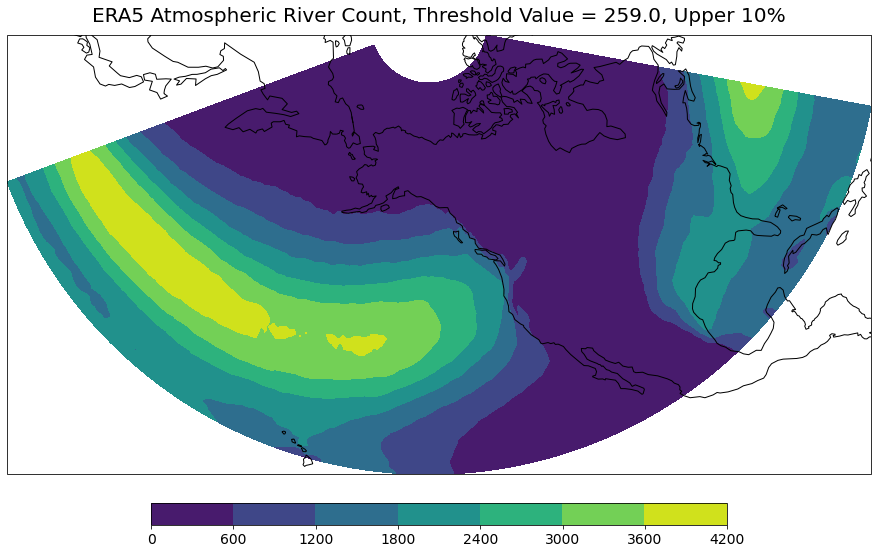

In [28]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

cs = axs.contourf(ds_ar['lon'], ds_ar['lat'], ds_ar, transform=ccrs.PlateCarree())
axs.coastlines()
cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
if era5 == False:
    plt.suptitle('Metis' + res + ' Atmospheric River Count, Threshold Value = ' + str(crit_val) + ', Upper '+ threshold,
                fontsize=20)
else:
    plt.suptitle('ERA5 Atmospheric River Count, Threshold Value = ' + str(crit_val) + ', Upper '+ threshold,
                fontsize=20)
#plt.savefig(f_pic)